(bart_categorical)=
# Categorical regression

:::{post} May, 2024
:tags: BART, regression
:category: beginner, reference
:author: Pablo Garay, Osvaldo Martin
:::

In this example, we will model outcomes with more than two categories.  
:::{include} ../extra_installs.md
:::

In [1]:
import os
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc_bart as pmb
import seaborn as sns

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
# set formats
RANDOM_SEED = 8457
az.style.use("arviz-darkgrid")

## Hawks dataset  

Here we will use a dataset that contains information about 3 species of hawks (*CH*=Cooper's, *RT*=Red-tailed, *SS*=Sharp-Shinned). This dataset has information for 908 individuals in total, each one containing 16 variables, in addition to the species. To simplify the example, we will use the following 5 covariables:  
- *Wing*: Length (in mm) of primary wing feather from tip to wrist it attaches to.  
- *Weight*: Body weight (in gr).  
- *Culmen*: Length (in mm) of the upper bill from the tip to where it bumps into the fleshy part of the bird.  
- *Hallux*: Length (in mm) of the killing talon.  
- *Tail*: Measurement (in mm) related to the length of the tail.  

Also we are going to eliminate the NaNs in the dataset. With these we will predict the "Species" of hawks, in other words, these are our dependent variables, the classes we want to predict.  

In [3]:
# Load data and eliminate NANs
try:
    Hawks = pd.read_csv(os.path.join("..", "data", "Hawks.csv"))[
        ["Wing", "Weight", "Culmen", "Hallux", "Tail", "Species"]
    ].dropna()
except FileNotFoundError:
    Hawks = pd.read_csv(pm.get_data("Hawks.csv"))[
        ["Wing", "Weight", "Culmen", "Hallux", "Tail", "Species"]
    ].dropna()

Hawks.head()

,Wing,Weight,Culmen,Hallux,Tail,Species
0,385.0,920.0,25.7,30.1,219,RT
2,381.0,990.0,26.7,31.3,235,RT
3,265.0,470.0,18.7,23.5,220,CH
4,205.0,170.0,12.5,14.3,157,SS
5,412.0,1090.0,28.5,32.2,230,RT


## EDA  
The following compares covariables to get a rapid data visualization for the 3 species.  

/home/pablo/anaconda3/envs/py310/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


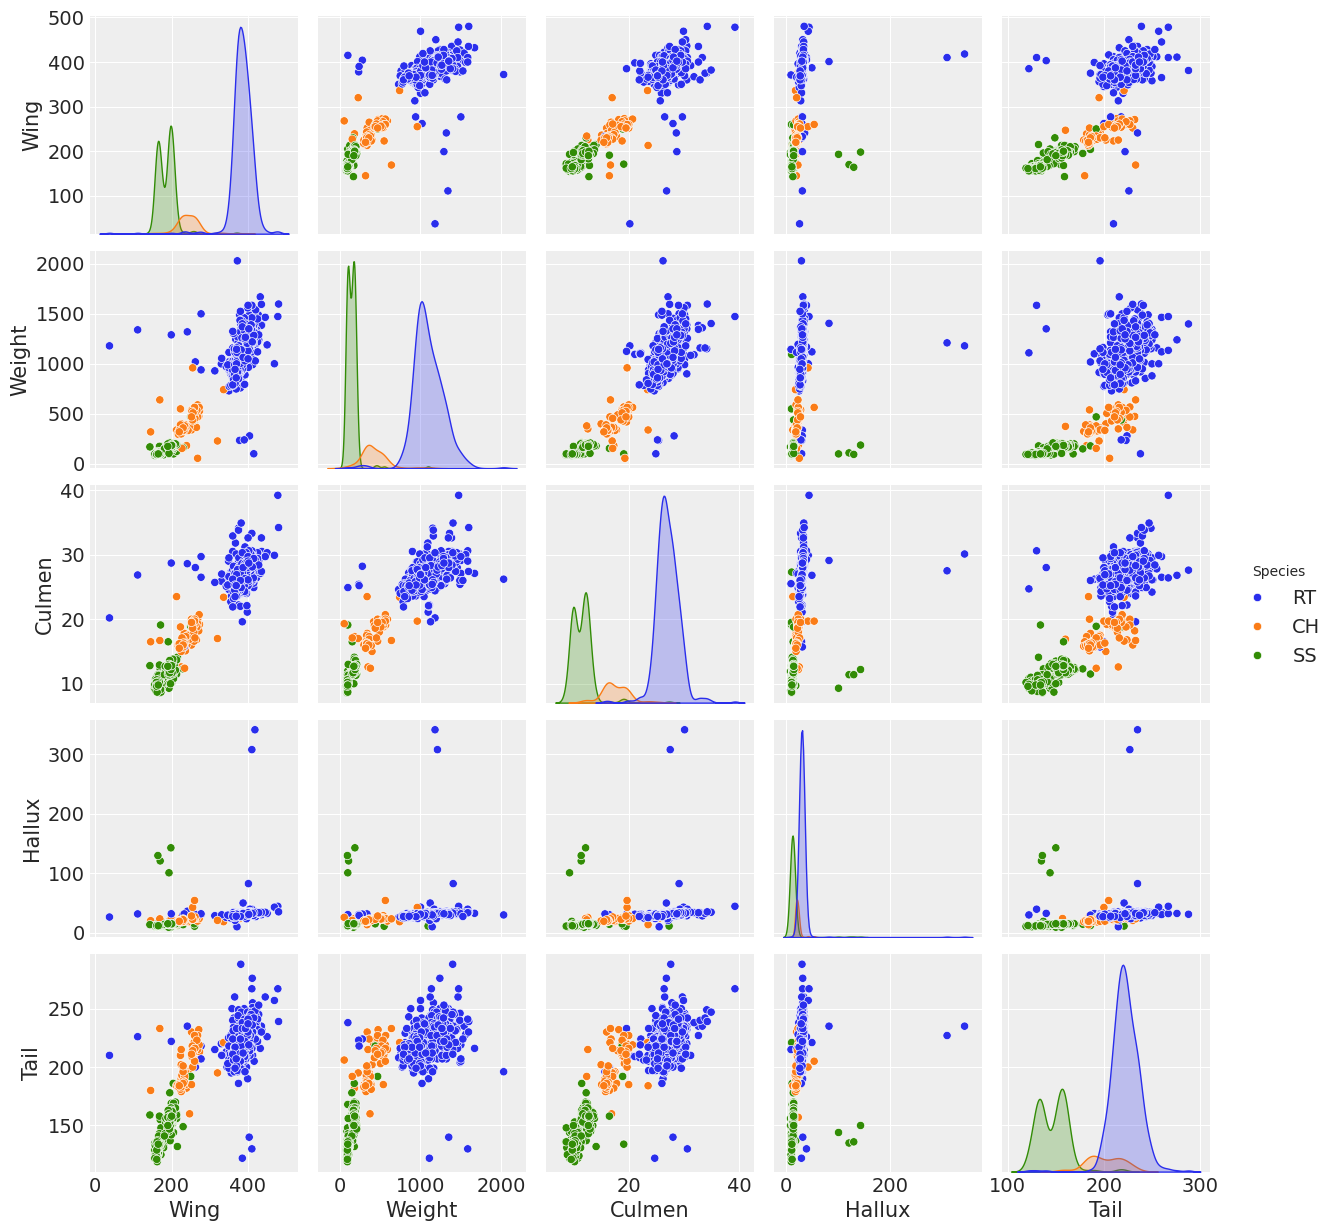

In [4]:
sns.pairplot(Hawks, hue="Species");

It can be seen that the RT species have distributions more differentiated than the other two in almost all covariables, and the covariables wing, weight, and culmen present certain separations between species. Still, none of the variables have a marked separation among the species distributions such that they can cleanly separate them. It is possible to make a combination of covariables, probably wing, weight, and culmen, to achieve the classification. These are the principal reasons for realizing the regression.  

## Model Specification  

First, we are going to prepare the data for the model, using "Species" as response and, "Wing", "Weight", "Culmen", "Hallux" and "Tail" as predictors. Using `pd.Categorical(Hawks['Species']).codes` we can codify the name species into integers between 0 and 2, being 0="CH", 1="RT" and 2="SS".  

In [5]:
y_0 = pd.Categorical(Hawks["Species"]).codes
x_0 = Hawks[["Wing", "Weight", "Culmen", "Hallux", "Tail"]]
print(len(x_0), x_0.shape, y_0.shape)

891 (891, 5) (891,)


We only can have an instance of {class}`~pymc_bart.BART()` in each pymc model (for now), so to model 3 species we can use coordinate and dimension names to specify the shapes of variables, *indicating* that there are 891 rows of information for 3 species. This step facilite the later selection of groups from the `InferenceData`.  

In [6]:
_, species = pd.factorize(Hawks["Species"], sort=True)
species

Index(['CH', 'RT', 'SS'], dtype='object')

In [7]:
coords = {"n_obs": np.arange(len(x_0)), "species": species}

In this model we use the `pm.math.softmax()` function, for $\mu$ from `pmb.BART()`, because guarantees that the vector sums to 1 along the `axis=0` in this case.  

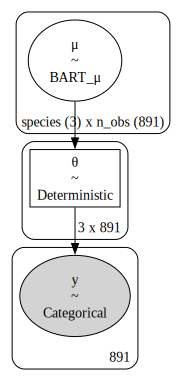

In [8]:
with pm.Model(coords=coords) as model_hawks:
    μ = pmb.BART("μ", x_0, y_0, m=50, dims=["species", "n_obs"])
    θ = pm.Deterministic("θ", pm.math.softmax(μ, axis=0))
    y = pm.Categorical("y", p=θ.T, observed=y_0)

pm.model_to_graphviz(model=model_hawks)

 Now fit the model and get samples from the posterior.

In [9]:
with model_hawks:
    idata = pm.sample(chains=4, compute_convergence_checks=False, random_seed=123)
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Multiprocess sampling (4 chains in 3 jobs)
PGBART: [μ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 155 seconds.
Sampling: [y]


Output()

## Results  

### Variable Importance  

It may be that some of the input variables are not informative for classifying by species, so in the interest of parsimony and in reducing the computational cost of model estimation, it is useful to quantify the importance of each variable in the dataset. PyMC-BART provides the function {func}`~pymc_bart.plot_variable_importance()`, which generates a plot that shows on his x-axis the number of covariables and on the y-axis the R$^2$ (the square of the Pearson correlation coefficient) between the predictions made for the full model (all variables included) and the restricted models, those with only a subset of the variables. The error bars represent the 94 % HDI from the posterior predictive distribution. 

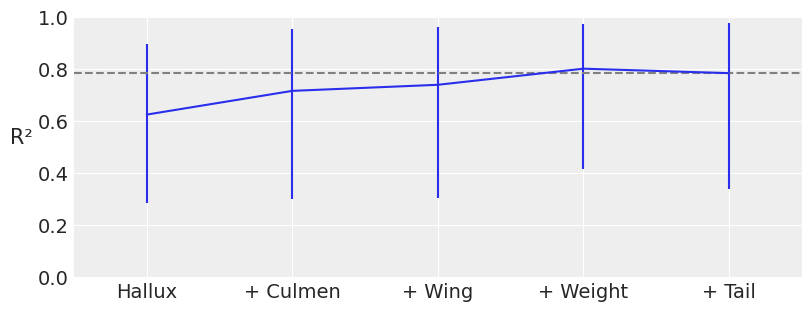

In [10]:
pmb.plot_variable_importance(idata, μ, x_0, method="VI", random_seed=RANDOM_SEED);

It can be observed that with the covariables `Hallux`, `Culmen`, and `Wing` we achieve the same R$^2$ value that we obtained with all the covariables, this is that the last two covariables contribute less than the other three to the classification. One thing we have to take into account in this is that the HDI is quite wide, which gives us less precision on the results, later we are going to see a way to reduce this.    

### Partial Dependence Plot

Let's check the behavior of each covariable for each species with `pmb.plot_pdp()`, which shows the marginal effect a covariate has on the predicted variable, while we average over all the other covariates.  

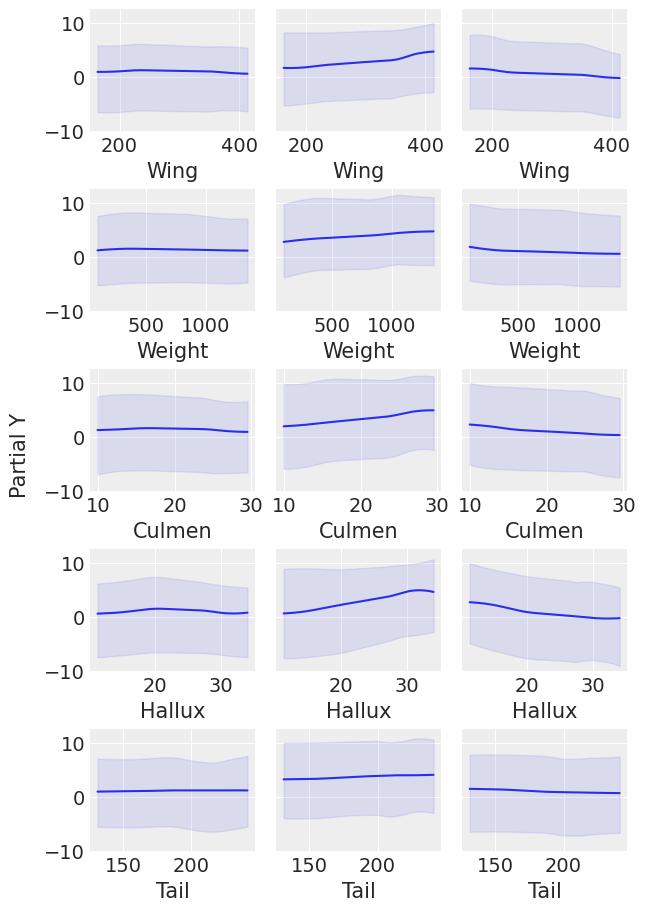

In [11]:
pmb.plot_pdp(μ, X=x_0, Y=y_0, grid=(5, 3), figsize=(6, 9));

The pdp plot, together with the Variable Importance plot, confirms that `Tail` is the covariable with the smaller effect over the predicted variable. In the Variable Importance plot `Tail` is the last covariable to be added and does not improve the result, in the pdp plot `Tail` has the flattest response. For the rest of the covariables in this plot, it's hard to see which of them have more effect over the predicted variable, because they have great variability, showed in the HDI wide, same as before later we are going to see a way to reduce this variability. Finally, some variability depends on the amount of data for each species, which we can see  in the `counts` from one of the covariables using Pandas `.describe()` and grouping the data from "Species" with `.groupby("Species")`.  

### Predicted vs Observed  

Now we are going to compare the predicted data with the observed data to evaluate the fit of the model, we do this with the Arviz function `az.plot_ppc()`.  

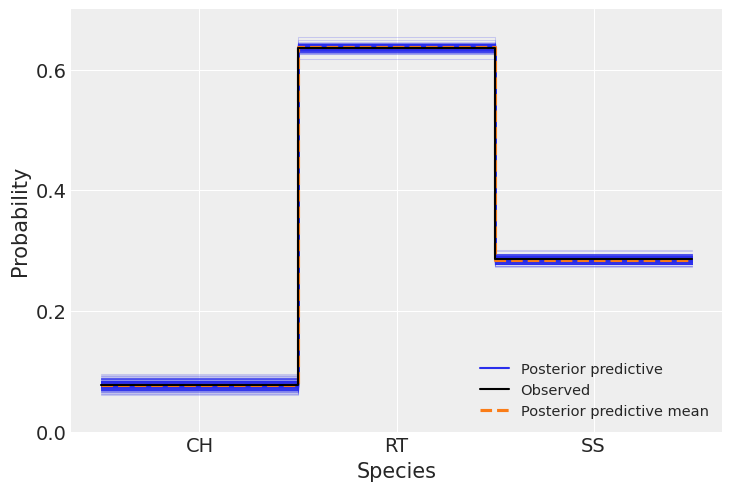

In [12]:
ax = az.plot_ppc(idata, kind="kde", num_pp_samples=200, random_seed=123)
# plot aesthetics
ax.set_ylim(0, 0.7)
ax.set_yticks([0, 0.2, 0.4, 0.6])
ax.set_ylabel("Probability")
ax.set_xticks([0.5, 1.5, 2.5])
ax.set_xticklabels(["CH", "RT", "SS"])
ax.set_xlabel("Species");

We can see a good agreement between the observed data (black line) and those predicted by the model (blue and orange lines). As we mentioned before, the difference in the values between species is influenced by the amount of data for each one. Here there is no observed dispersion in the predicted data as we saw in the previous two plots.  

Below we see that the in-sample predictions provide very good agreement with the observations.  

In [13]:
np.mean((idata.posterior_predictive["y"] - y_0) == 0) * 100

<xarray.DataArray 'y' ()> Size: 8B
array(96.34186308)

In [14]:
all = 0
for i in range(3):
    perct_per_class = np.mean(idata.posterior_predictive["y"].where(y_0 == i) == i) * 100
    all += perct_per_class
    print(perct_per_class)
all

<xarray.DataArray 'y' ()> Size: 8B
array(6.06369248)
<xarray.DataArray 'y' ()> Size: 8B
array(62.75785634)
<xarray.DataArray 'y' ()> Size: 8B
array(27.52031425)


<xarray.DataArray 'y' ()> Size: 8B
array(96.34186308)

So far we have a very good result concerning the classification of the species based on the 5 covariables. However, if we want to select a subset of covariable to perform future classifications is not very clear which of them to select. Maybe something sure is that `Tail` could be eliminated. At the beginning when we plot the distribution of each covariable we said that the most important variables to make the classification could be `Wing`, `Weight` and, `Culmen`, nevertheless after running the model we saw that `Hallux`, `Culmen` and, `Wing`, proved to be the most important ones.

Unfortunatelly, the partial dependence plots show a very wide dispersion, making results look suspicious. One way to reduce this variability is adjusting independent trees, below we will see how to do this and get a more accurate result. 

## Fitting independent trees  

The option to fit independent trees with `pymc-bart` is set with the parameter `pmb.BART(..., separate_trees=True, ...)`. As we will see, for this example, using this option doesn't give a big difference in the predictions, but helps us to reduce the variability in the ppc and get a small improvement in the in-sample comparison. In case this option is used with bigger datasets you have to take into account that the model fits more slowly, so you can obtain a better result at the expense of computational cost. The following code runs the same model and analysis as before, but fitting independent trees. Compare the time to run this model with the previous one.  

In [15]:
with pm.Model(coords=coords) as model_t:
    μ_t = pmb.BART("μ", x_0, y_0, m=50, separate_trees=True, dims=["species", "n_obs"])
    θ_t = pm.Deterministic("θ", pm.math.softmax(μ_t, axis=0))
    y_t = pm.Categorical("y", p=θ_t.T, observed=y_0)
    idata_t = pm.sample(chains=4, compute_convergence_checks=False, random_seed=123)
    pm.sample_posterior_predictive(idata_t, extend_inferencedata=True)

Multiprocess sampling (4 chains in 3 jobs)
PGBART: [μ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 423 seconds.
Sampling: [y]


Output()

Now we are going to reproduce the same analyses as before.  

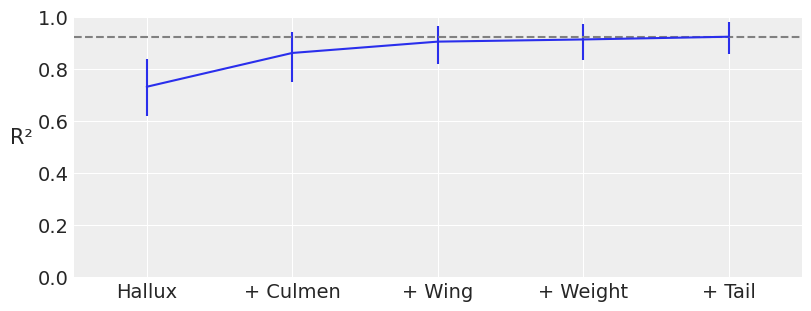

In [16]:
pmb.plot_variable_importance(idata_t, μ_t, x_0, method="VI", random_seed=RANDOM_SEED);

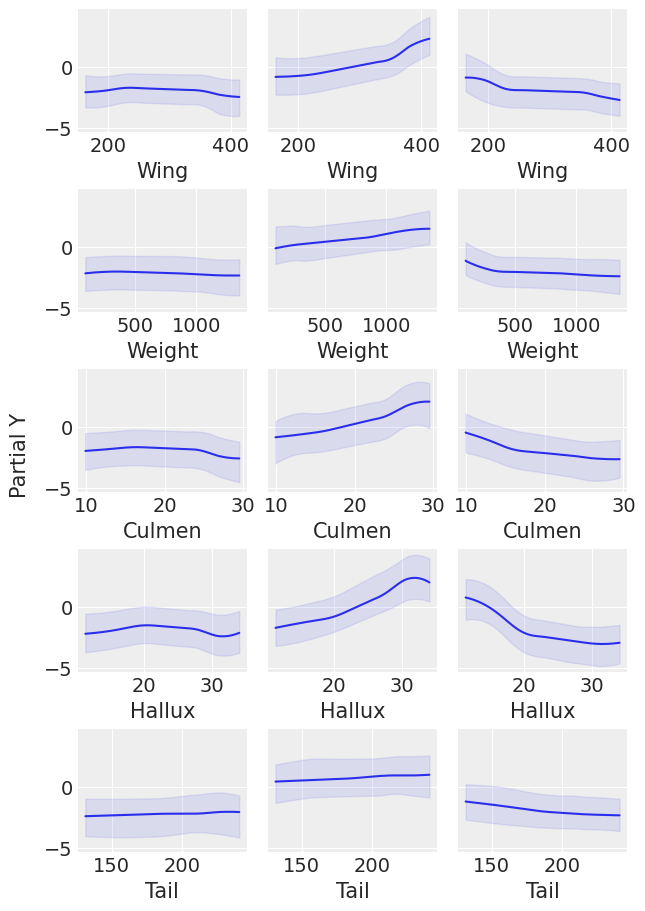

In [17]:
pmb.plot_pdp(μ_t, X=x_0, Y=y_0, grid=(5, 3), figsize=(6, 9));

Comparing these two plots with the previous ones shows a marked reduction in the variance for each one. In the case of `pmb.plot_variable_importance()` there are smallers error bands with an R$^{2}$ value more close to 1. And for `pm.plot_pdp()` we can see thinner bands and a reduction in the limits on the y-axis, this is a representation of the reduction of the uncertainty due to adjusting the trees separately. Another benefit of this is that is more visible the behavior of each covariable for each one of the species.   

With all these together, we can select `Hallux`, `Culmen`, and, `Wing` as covariables to make the classification.

Concerning the comparison between observed and predicted data, we obtain the same good result with less uncertainty for the predicted values (blue lines). And the same counts for the in-sample comparison.  

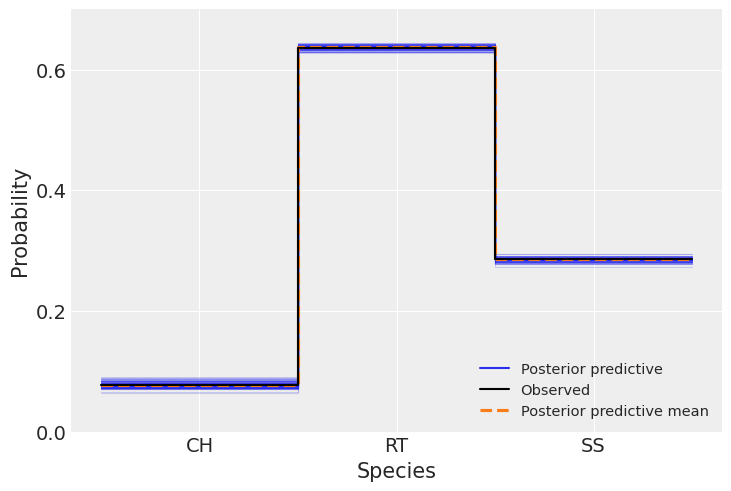

In [18]:
ax = az.plot_ppc(idata_t, kind="kde", num_pp_samples=100, random_seed=123)
ax.set_ylim(0, 0.7)
ax.set_yticks([0, 0.2, 0.4, 0.6])
ax.set_ylabel("Probability")
ax.set_xticks([0.5, 1.5, 2.5])
ax.set_xticklabels(["CH", "RT", "SS"])
ax.set_xlabel("Species");

In [19]:
np.mean((idata_t.posterior_predictive["y"] - y_0) == 0) * 100

<xarray.DataArray 'y' ()> Size: 8B
array(97.26565657)

In [20]:
all = 0
for i in range(3):
    perct_per_class = np.mean(idata_t.posterior_predictive["y"].where(y_0 == i) == i) * 100
    all += perct_per_class
    print(perct_per_class)
all

<xarray.DataArray 'y' ()> Size: 8B
array(6.48922559)
<xarray.DataArray 'y' ()> Size: 8B
array(62.95244108)
<xarray.DataArray 'y' ()> Size: 8B
array(27.8239899)


<xarray.DataArray 'y' ()> Size: 8B
array(97.26565657)

## Authors
- Authored by [Pablo Garay](https://github.com/PabloGGaray) and [Osvaldo Martin](https://aloctavodia.github.io/) in May, 2024  

## References  
:::{bibliography} :filter: docname in docnames :::

## Watermark  

In [21]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Wed May 29 2024

Python implementation: CPython
Python version       : 3.10.0
IPython version      : 8.24.0

pytensor: 2.20.0

numpy     : 1.26.4
arviz     : 0.18.0
pymc      : 5.15.0
seaborn   : 0.13.2
pymc_bart : 0.5.14
pandas    : 2.2.2
matplotlib: 3.8.4

Watermark: 2.4.3



:::{include} ../page_footer.md :::